In [ ]:
!unzip '/content/drive/MyDrive/ML/Kaggle-competitions/Song-popularity-mlspace/train.csv.zip' -d '/content/data'
!unzip '/content/drive/MyDrive/ML/Kaggle-competitions/Song-popularity-mlspace/test.csv.zip' -d '/content/data'

Archive:  /content/drive/MyDrive/ML/Kaggle-competitions/Song-popularity-mlspace/train.csv.zip
  inflating: /content/data/train.csv  
Archive:  /content/drive/MyDrive/ML/Kaggle-competitions/Song-popularity-mlspace/test.csv.zip
  inflating: /content/data/test.csv  


Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head(10)

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0
5,5,188891.0,0.035655,0.825919,0.804528,-0.000005,4.0,0.120758,-6.122926,0,0.039012,115.679128,4,0.709408,0
6,6,161061.0,0.081743,0.673588,0.880181,0.000327,0.0,0.535411,-2.909607,1,0.030902,98.046205,4,0.982729,0
7,7,196202.0,0.259747,0.813214,0.554385,0.000390,8.0,0.276580,-7.794237,0,0.207067,158.626764,3,0.662987,1
8,8,169660.0,NaN,0.653263,0.917034,0.001748,0.0,NaN,-4.422089,0,0.031608,122.382398,3,0.297683,1
9,9,167245.0,0.019617,0.595235,0.820039,0.761884,5.0,0.181098,-5.154293,0,0.054493,110.524824,4,0.535453,0


In [3]:
df.shape

(40000, 15)

In [4]:
df_test.shape

(10000, 14)

In [5]:
df.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,40000.00000,35899.000000,36008.000000,35974.000000,36025.000000,36015.000000,35935.000000,35914.000000,36043.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,19999.50000,193165.847572,0.276404,0.570951,0.683932,0.036527,5.042605,0.198514,-7.407596,0.321150,0.094107,116.562815,3.394375,0.580645,0.364400
std,11547.14972,45822.127679,0.297928,0.190010,0.212662,0.150024,3.372728,0.151670,3.877198,0.466924,0.083591,26.167911,0.524405,0.237351,0.481268
min,0.00000,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-32.117911,0.000000,0.015065,62.055779,2.000000,0.013398,0.000000
25%,9999.75000,166254.500000,0.039618,0.424760,0.539276,0.000941,2.000000,0.111796,-9.578139,0.000000,0.038500,96.995309,3.000000,0.398669,0.000000
50%,19999.50000,186660.000000,0.140532,0.608234,0.704453,0.001974,5.000000,0.135945,-6.345413,0.000000,0.055881,113.795959,3.000000,0.598827,0.000000
75%,29999.25000,215116.000000,0.482499,0.718464,0.870503,0.003225,8.000000,0.212842,-4.620711,1.000000,0.118842,128.517383,4.000000,0.759635,1.000000
max,39999.00000,491671.000000,1.065284,0.957131,1.039741,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,219.163578,5.000000,1.022558,1.000000


In [6]:
df.astype('object').describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,40000,35899.0,36008.000000,35974.000000,36025.000000,36015.00000,35935.0,35914.000000,36043.000000,40000,40000.000000,40000.000000,40000,40000.000000,40000
unique,40000,31586.0,36004.000000,35972.000000,36021.000000,35999.00000,12.0,35911.000000,36038.000000,2,39999.000000,39993.000000,4,39998.000000,2
top,39999,162048.0,0.129865,0.348442,0.798807,0.00238,0.0,0.136466,-11.109011,0,0.033324,111.827571,3,0.685907,0
freq,1,6.0,2.000000,2.000000,2.000000,2.00000,5175.0,2.000000,2.000000,27154,2.000000,2.000000,23358,2.000000,25424


Initial discoveries 
* Various scales can be seen some falling under 0-1, some going very small and very high 
* Many null values(NA) can bee seen lot in the sample data itself in various columns  

In [7]:
#null value count 
print("Null value percentage in train set%")
print('-'*30)
print(df.isna().sum()/df.shape[0] * 100)
print('-'*30)

print("Null value percentage in test set%")
print('-'*30)
print((df_test.isna().sum()/df_test.shape[0]) * 100)
print('-'*30)

Null value percentage in train set%
------------------------------
id                   0.0000
song_duration_ms    10.2525
acousticness         9.9800
danceability        10.0650
energy               9.9375
instrumentalness     9.9625
key                 10.1625
liveness            10.2150
loudness             9.8925
audio_mode           0.0000
speechiness          0.0000
tempo                0.0000
time_signature       0.0000
audio_valence        0.0000
song_popularity      0.0000
dtype: float64
------------------------------
Null value percentage in test set%
------------------------------
id                   0.00
song_duration_ms     9.57
acousticness         9.50
danceability         9.76
energy              10.55
instrumentalness    10.00
key                  9.92
liveness            10.06
loudness            10.26
audio_mode           0.00
speechiness          0.00
tempo                0.00
time_signature       0.00
audio_valence        0.00
dtype: float64
----------------------

In [8]:
print(f"Total missing values:\nTrain set :{sum(df.isna().sum())/(df.shape[0]*df.shape[1])*100}\nTest set :{sum(df_test.isna().sum())/(df_test.shape[0]*df_test.shape[1])*100}")

Total missing values:
Train set :5.3645
Test set :5.687142857142858


In [9]:
null_train = df.isna().sum()/df.shape[0] * 100
null_test = df_test.isna().sum()/df_test.shape[0] * 100

In [ ]:
fig = px.bar(y=df_test.columns,x=null_test,orientation = 'h', barmode='relative',width = 1000,
             title = "Missing values % : Train VS Test set")
fig.add_bar(name='train set',y=df.columns,x=null_train,orientation='h')
fig.show()

key points : 
* overall missing values are around 5% across the dataset
* not all features have missing values 

In [10]:
df.shape[0]*14

560000

Total number of features: 13
Number of categorical features: 3
Number of continuos features: 10


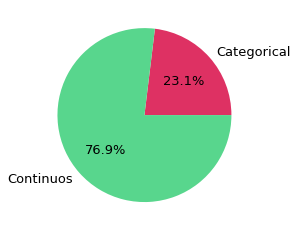

In [11]:
FEATURES = [col for col in df.columns if col not in ['id', 'song_popularity']]
data = pd.concat([df[FEATURES], df_test[FEATURES]], axis=0)

cat_features = [col for col in FEATURES if df[col].nunique() < 15]
cont_features = [col for col in FEATURES if df[col].nunique() >= 15]


print(f'Total number of features: {len(FEATURES)}')
print(f'\033[92mNumber of categorical features: {len(cat_features)}')
print(f'\033[96mNumber of continuos features: {len(cont_features)}')

plt.pie([len(cat_features), len(cont_features)], 
        labels=['Categorical', 'Continuos'],
        colors=['#DE3163', '#58D68D'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.show()

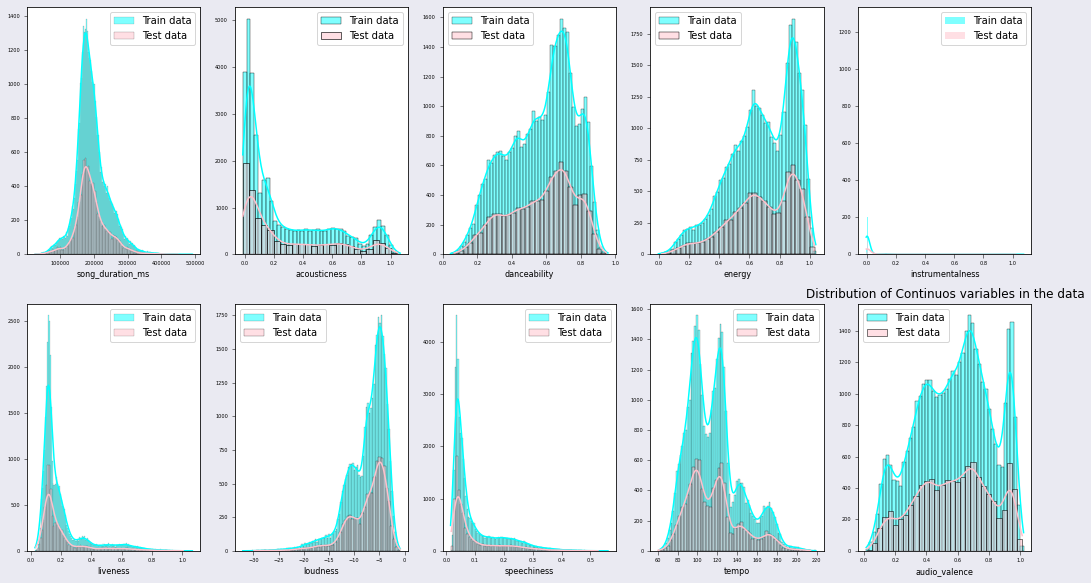

In [ ]:


ncols = 5
nrows = int(len(cont_features) / ncols + (len(FEATURES) % ncols > 0))-1

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = cont_features[r*ncols+c]
        sns.histplot(x= df[col], ax=axes[r, c], color='cyan', label='Train data' , fill =True , kde = True)
        sns.histplot(x=df_test[col], ax=axes[r, c], color='pink', label='Test data', fill =True, kde = True)
        axes[r,c].legend()
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8)
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.title("Distribution of Continuos variables in the data")
plt.show()



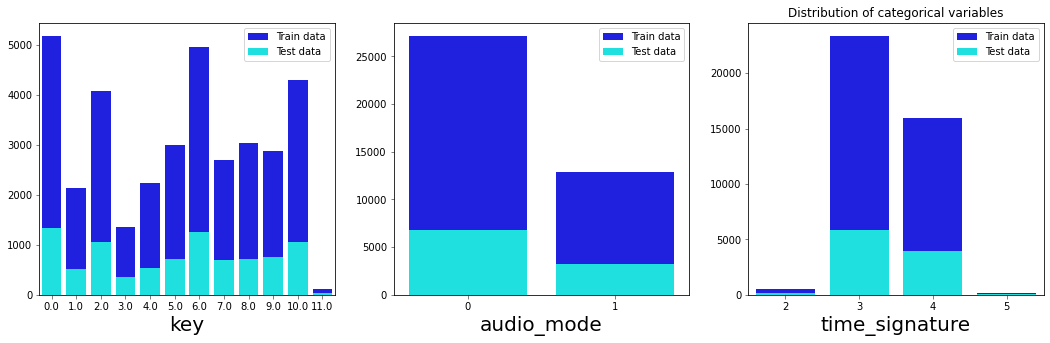

In [ ]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 3
    nrows = 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5))
    plt.title("Distribution of categorical variables")
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[c]
            sns.countplot( x =df[col],ax = axes[c] ,color = "blue", label='Train data')
            sns.countplot( x = df_test[col],ax = axes[c] ,color = "cyan", label='Test data')
            axes[c].legend()
            axes[c].set_ylabel('')
            axes[c].set_xlabel(col, fontsize=20)
            axes[c].tick_params(labelsize=10, width=0.5)
            axes[c].xaxis.offsetText.set_fontsize(4)
            axes[c].yaxis.offsetText.set_fontsize(4)
    plt.show()

In [ ]:
df.song_popularity.value_counts()

0    25424
1    14576
Name: song_popularity, dtype: int64

In [ ]:
px.pie(df, df.song_popularity.unique(), values = df.song_popularity.value_counts(), title = 'Target class distribution', width = 1000)

* Class imbalance can be noted, not heavy but maybe considered later

In [70]:
features_ = data.columns

X_train = df[features_]


X_test = df_test[features_]
X_train.shape,X_test.shape

((40000, 13), (10000, 13))

In [71]:
y_train = df['song_popularity']
y_train.shape
y_train

0        0
1        1
2        0
3        0
4        0
        ..
39995    0
39996    0
39997    1
39998    0
39999    0
Name: song_popularity, Length: 40000, dtype: int64

In [72]:
X_train

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642
1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531
2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536
3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597
4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,237799.0,NaN,0.748942,0.511234,0.002913,0.0,0.173803,-8.853673,0,0.078060,168.262924,3,0.178159
39996,191119.0,0.067488,0.672830,0.889685,0.001225,5.0,0.122924,-7.798993,0,0.188607,110.684544,3,0.790626
39997,160879.0,0.877431,0.409065,0.292671,NaN,10.0,0.110664,-15.378585,0,0.031294,99.556074,3,0.177947
39998,193918.0,NaN,0.365738,NaN,0.000339,1.0,0.356308,-4.661977,1,0.054096,139.857384,3,0.772978


In [73]:
X_train.instrumentalness = np.log1p(X_train.instrumentalness)
X_train.instrumentalness.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.instrumentalness.isna().sum()

3985

In [74]:
X_test.instrumentalness = np.log1p(X_test.instrumentalness)
X_test.instrumentalness.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.instrumentalness.isna().sum()

1000

In [77]:
X_test.instrumentalness.isna().sum()

0

In [76]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer  


imputer = IterativeImputer(random_state = 10,max_iter= 10, initial_strategy= 'median') 

X_train = pd.DataFrame(imputer.fit_transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test),columns = X_train.columns) 





In [78]:
X_train.isnull().sum()

song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold 
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.metrics import roc_auc_score

In [87]:
from sklearn.model_selection import StratifiedKFold 
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.metrics import roc_auc_score



xgb_score = []
final_pred = []
skf= StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
for fold,(train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train)):
  print(10*"=", f"Fold={fold+1}", 10*"=")
  start_time = time.time()
  x_train,x_valid = X_train.iloc[train_indicies],X_train.iloc[valid_indicies]
  y_train1,y_valid = y_train.iloc[train_indicies],y_train.iloc[valid_indicies] 

  model = XGBClassifier(n_estimators=1000,max_depth = 12,booster='gbtree')
  model.fit(x_train,y_train1,verbose = 0,
            eval_set = [(x_valid, y_valid)],
            eval_metric = 'auc',
            early_stopping_rounds = 300) 
  
  preds_valid = model.predict_proba(x_valid)[:, 1]
  auc = roc_auc_score(y_valid,  preds_valid)
  xgb_score.append(auc)
  run_time = time.time() - start_time


  print(f"Fold={fold+1}, AUC score: {auc:.2f}, Run Time: {run_time:.2f}s")
  test_preds = model.predict_proba(X_test[FEATURES])[:, 1]
  final_pred.append(test_preds)
  


========== Fold=1 ==========
Fold=1, AUC score: 0.55, Run Time: 43.48s
========== Fold=2 ==========
Fold=2, AUC score: 0.54, Run Time: 122.53s
========== Fold=3 ==========


KeyboardInterrupt: ignored

In [ ]:
np.array(xgb_score).mean()

0.5708124026147339

In [ ]:
final_pred

submit = pd.DataFrame(df_test['id'])
ans = np.mean(np.stack(final_pred), axis = 0)
submit['song_popularity'] = ans
submit.head()

,id,song_popularity
0,0,0.370162
1,1,0.455548
2,2,0.304105
3,3,0.320673
4,4,0.387369


In [ ]:
submit.to_csv('submit_this_file.csv',index=False)

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [60]:
model = CatBoostClassifier()
parameters = {'depth':[i for i in range(2,8,2)], 'learning_rate':[0.06, 0.07, 0.075, 0.08]}
n_folds = 5
grid_model = RandomizedSearchCV(estimator=model, param_distributions=parameters, cv=n_folds, scoring='roc_auc',
                                return_train_score=True)
grid_model.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
0:	learn: 0.6871438	total: 10.7ms	remaining: 10.7s
1:	learn: 0.6819895	total: 16.4ms	remaining: 8.19s
2:	learn: 0.6777660	total: 21.8ms	remaining: 7.23s
3:	learn: 0.6742102	total: 27ms	remaining: 6.71s
4:	learn: 0.6711894	total: 32.2ms	remaining: 6.4s
5:	learn: 0.6685615	total: 37.6ms	remaining: 6.23s
6:	learn: 0.6664396	total: 42.2ms	remaining: 5.99s
7:	learn: 0.6646076	total: 46.8ms	remaining: 5.8s
8:	learn: 0.6630641	total: 51.6ms	remaining: 5.68s
9:	learn: 0.6614865	total: 56.9ms	remaining: 5.63s
10:	learn: 0.6602631	total: 62.2ms	remaining: 5.59s
11:	learn: 0.6592452	total: 67.7ms	remaining: 5.58s
12:	learn: 0.6582892	total: 73.1ms	remaining: 5.55s
13:	learn: 0.6574704	total: 78.4ms	remaining: 5.52s
14:	learn: 0.6567827	total: 83.6ms	remaining: 5.49s
15:	learn: 0.6561222	total: 89ms	remaining: 5.47s
16:	learn: 0.6556300	total: 94.3ms	remaining: 5.45s
17:	learn: 0.6551391	total: 99.8ms	remaining: 5.44s
18:	learn: 0.6547225	total: 1

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f5207cd6950>,
                   param_distributions={'depth': [2, 4, 6],
                                        'learning_rate': [0.06, 0.07, 0.075,
                                                          0.08]},
                   return_train_score=True, scoring='roc_auc')

In [61]:
grid_model.best_params_

{'depth': 2, 'learning_rate': 0.075}

In [62]:
grid_model.best_score_

0.5746829316969485

In [97]:
cat_params = {
            'depth' : 4,
            'grow_policy' : 'SymmetricTree',
            'learning_rate' : 0.08,
            'iterations' : 1000,
            'loss_function' : 'CrossEntropy',
            'eval_metric' : 'AUC',
            'use_best_model' : True,
            'early_stopping_rounds' : 100,
            'task_type' : 'CPU',
            'thread_count' : 4,
            'verbose' : False
        }
        


cat_score = []
final_pred = []
skf= StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
for fold,(train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train)):
  print(10*"=", f"Fold={fold+1}", 10*"=")
  start_time = time.time()
  x_train,x_valid = X_train.iloc[train_indicies],X_train.iloc[valid_indicies]
  y_train1,y_valid = y_train.iloc[train_indicies],y_train.iloc[valid_indicies] 

  model = CatBoostClassifier(**cat_params) 
  model.fit(x_train,y_train1,verbose = 0,
            eval_set = [(x_valid, y_valid)]) 
  
  preds_valid = model.predict_proba(x_valid)[:, 1]
  auc = roc_auc_score(y_valid,  preds_valid)
  cat_score.append(auc)
  run_time = time.time() - start_time


  print(f"Fold={fold+1}, AUC score: {auc:.2f}, Run Time: {run_time:.2f}s")
  test_preds = model.predict_proba(X_test[FEATURES])[:, 1]
  final_pred.append(test_preds)
  


========== Fold=1 ==========
Fold=1, AUC score: 0.58, Run Time: 4.46s
========== Fold=2 ==========
Fold=2, AUC score: 0.56, Run Time: 3.30s
========== Fold=3 ==========
Fold=3, AUC score: 0.57, Run Time: 2.95s
========== Fold=4 ==========
Fold=4, AUC score: 0.59, Run Time: 2.01s
========== Fold=5 ==========
Fold=5, AUC score: 0.58, Run Time: 2.59s
========== Fold=6 ==========
Fold=6, AUC score: 0.58, Run Time: 1.97s
========== Fold=7 ==========
Fold=7, AUC score: 0.59, Run Time: 2.25s
========== Fold=8 ==========
Fold=8, AUC score: 0.58, Run Time: 2.70s
========== Fold=9 ==========
Fold=9, AUC score: 0.58, Run Time: 4.45s
========== Fold=10 ==========
Fold=10, AUC score: 0.58, Run Time: 2.43s


In [98]:
np.array(cat_score).mean()

# 5780690942749

0.5785651238068861

In [84]:
cat_score

[0.5798659757726473,
 0.5561657271188138,
 0.5687209509140113,
 0.5963454660822191,
 0.5775903099532788,
 0.5772047435727244,
 0.5855528358150965,
 0.5764983665368315,
 0.5791018165060184,
 0.5767061244885646]

In [100]:
final_pred

submit = pd.DataFrame(df_test['id'])
ans = np.mean(np.stack(final_pred), axis = 0)
submit['song_popularity'] = ans
submit.head()

,id,song_popularity
0,0,0.376230
1,1,0.466213
2,2,0.257529
3,3,0.303634
4,4,0.373386


In [99]:
submit.to_csv('submit_this_file.csv',index=False)

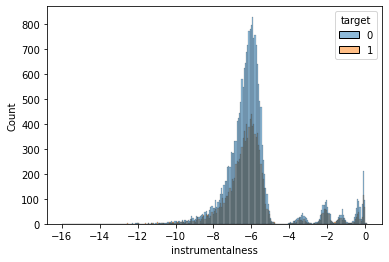

In [ ]:
check = pd.DataFrame(df['instrumentalness'].apply(np.log))
check['target'] = df.song_popularity

sns.histplot(data = check,x='instrumentalness',hue = 'target')

In [ ]:
df.energy.shape

(40000,)

In [ ]:
len(np.log(df.instrumentalness.values))

40000

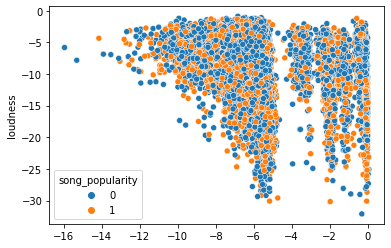

In [ ]:
sns.scatterplot(x=np.log(df.instrumentalness.values), y = df.loudness , hue = df.song_popularity)

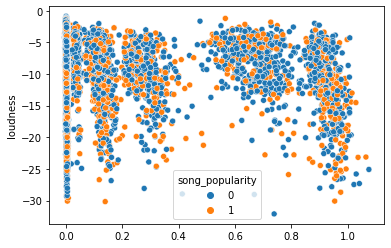

In [ ]:
sns.scatterplot(x=df.instrumentalness.values, y = df.loudness , hue = df.song_popularity)